### Dataprep

In [21]:
# Libraries
import jax
import jax.numpy as jnp
import jax.random as random
from flax import linen as nn
import gymnax
import optax
from gymnax.environments import environment, spaces
import matplotlib.pyplot as plt

Text(0.5, 1.0, 'Constant stock price')

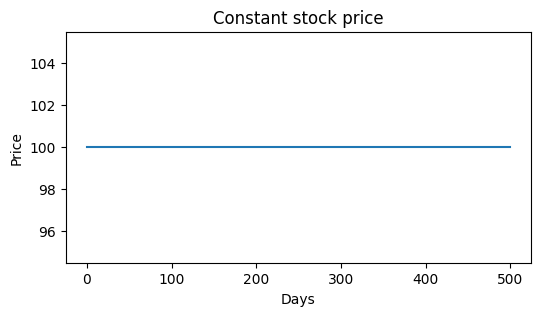

In [18]:
# constant price
data = jnp.array([jnp.arange(500), jnp.repeat(100,500)])
plt.figure(figsize=(6,3))
plt.plot(data[0],data[1])
plt.xlabel("Days")
plt.ylabel("Price")
plt.title("Constant stock price")

In [147]:
class TradingSimulator:
    
    def __init__(self, trading_days, training):
        self.trading_days = jnp.int32(trading_days)
        
        self.initial_state = {
            'counter': jnp.int32(0),
            'done': jnp.bool_(False),
            'training': jnp.bool_(training),
            'states': jnp.array([100.], dtype=jnp.float32),
            'actions': jnp.array([0], dtype=jnp.int32),
            'rewards': jnp.array([0.], dtype=jnp.float32)
        }
    
    def take_step(self, simulator_state, action):
        curr_action = action
        last_action = simulator_state['actions'][-1]

        # REWARD
        reward = jnp.where(curr_action != last_action, 0.05, -0.05)
        rewards = jnp.concatenate([simulator_state['rewards'], jnp.array([reward])])

        # Update stock price based on action
        last_state = simulator_state['states'][-1]
        new_state = jnp.where(curr_action == 1, last_state + 5.0, last_state - 5.0)
        states = jnp.concatenate([simulator_state['states'], jnp.array([new_state])])

        # Update actions
        actions = jnp.concatenate([simulator_state['actions'], jnp.array([curr_action])])

        # Increment counter
        counter = simulator_state['counter'] + 1
        done = counter >= self.trading_days

        # Update simulator state
        simulator_state = {
            'counter': counter,
            'done': done,
            'training': simulator_state['training'],
            'states': states,
            'actions': actions,
            'rewards': rewards
        }

        info = {'reward': reward}

        return simulator_state, reward, info
    
    def reset(self, training):
        new_state = self.initial_state.copy()
        new_state['training'] = jnp.bool_(training)
        return new_state
        
    def result(self, simulator_state):
        result = {
            'states': simulator_state['states'],
            'actions': simulator_state['actions'],
            'rewards': simulator_state['rewards']
        }
        return result

class TradingEnvironment(environment.Environment):
    
    def __init__(self, trading_days, training):
        self.trading_days = jnp.int32(trading_days)
        self.training = jnp.bool_(training)
        self.num_features = 1

        # Initialize the simulator
        self.simulator = TradingSimulator(trading_days=self.trading_days, training=self.training)
        
        # Action Space (0,1)
        self._action_space = spaces.Discrete(2)
        
        # Observation Space
        self._observation_space = spaces.Box(
            low=-jnp.inf, 
            high=jnp.inf, 
            shape=(self.num_features,), 
            dtype=jnp.float32
        )
    
    def step(self, env_state, action):
       # Perform a step using the simulator's state
       env_state, reward, info = self.simulator.take_step(env_state, action)
       # Extract observation (last price) from the env_state
       observation = env_state['states'][-1]
       return observation, reward, env_state, info
    
    def reset(self, training):
        
        # RNG_KEY will be not used in the beginning
          
        # Reset the simulator and return the initial state
        env_state = self.simulator.reset(training)
        # Extract the initial observation (last price) for the first step
        observation = env_state['states'][-1]
        return observation, env_state
    
    @property
    def action_space(self):
        return self._action_space

    @property
    def observation_space(self):
        return self._observation_space
        

In [43]:
a = jnp.array([1,2,3,4.])

a = jnp.concatenate([a,jnp.array([a[-1] + 1])])
print(a)

[1. 2. 3. 4. 5.]


In [18]:
abc = TradingEnvironment(trading_days=252, training=False)
simulator_state = abc.simulator.initial_state
print(simulator_state['states'])
observation, reward, simulator_state, info = abc.step(env_state=simulator_state, action=0)
print(observation)
print(reward)
print(simulator_state['states'])
observation, reward, simulator_state, info = abc.step(env_state=simulator_state, action=0)
print(observation)
print(reward)
print(simulator_state['states'])
observation, reward, simulator_state, info = abc.step(env_state=simulator_state, action=1)
print(observation)
print(reward)
print(simulator_state['states'])

[100.]
95.0
-0.05
[100.  95.]
90.0
-0.05
[100.  95.  90.]
95.0
0.05
[100.  95.  90.  95.]


In [6]:

print(abc.simulator.status()[0])
print("")
observation, reward, done, info = abc.step(action=0)
print(observation)
print(reward)
print(done)
print(info)
print(abc.simulator.rewards)
print("")
observation, reward, done, info = abc.step(action=0)
print(observation)
print(reward)
print(done)
print(info)
print(abc.simulator.rewards)
print("")
observation, reward, done, info = abc.step(action=1)
print(observation)
print(reward)
print(done)
print(info)
print(abc.simulator.rewards)

rng_key = jax.random.PRNGKey(0)
obs, done = abc.reset(rng_key, training=False)
print(obs, done)



[100.]

[100.  95.]
-0.05
False
{'reward': -0.05}
[ 0.   -0.05]

[100.  95.  90.]
-0.05
False
{'reward': -0.05}
[ 0.   -0.05 -0.05]

[100.  95.  90.  95.]
0.05
False
{'reward': 0.05}
[ 0.   -0.05 -0.05  0.05]
[100.] False


## PPO implementation

#### Policy/Value Network 

In [148]:
class PolicyNetwork(nn.Module):
    
    # Number of possible actions
    n_actions: int  

    @nn.compact
    def __call__(self, x):
        # A simple feedforward network
        x = nn.Dense(64)(x)
        x = nn.relu(x)
        x = nn.Dense(64)(x)
        x = nn.relu(x)
        # Output logits for each action
        logits = nn.Dense(self.n_actions)(x)  
        # Raw logits are returned; softmax can be applied later
        return logits
    
class ValueNetwork(nn.Module):
    @nn.compact
    def __call__(self, x):
        x = nn.Dense(64)(x)
        x = nn.relu(x)
        x = nn.Dense(64)(x)
        x = nn.relu(x)
        value = nn.Dense(1)(x)
        return value

$J(s,a,\theta_k,\theta) = min(\frac{\pi_{\theta}(a|s)}{\pi_{\theta_k}(a|s)}*A(s,a), clip(\frac{\pi_{\theta}(a|s)}{\pi_{\theta_k}(a|s)}, 1 - \epsilon, 1 + \epsilon)*A(s,a))$

In [149]:
def ppo_clipped_objective(logits, old_logits, actions, advantages, epsilon=0.2):
    
    """Compute PPO clipped objective.
    Args:
        logits: Logits from the policy network (new policy).
        old_logits: Logits from the old policy.
        actions: Actions taken by the agent.
        advantages: Advantage estimates.
        epsilon: Clipping parameter.
    Returns:
        Clipped surrogate objective.
    """

    # Get the probabilities from logits
    probs = nn.softmax(logits)
    old_probs = nn.softmax(old_logits)
    
    # Select the probabilities of the actions taken
    probs_act = jnp.take_along_axis(probs, actions[:, None], axis=-1).squeeze()
    old_probs_act = jnp.take_along_axis(old_probs, actions[:, None], axis=-1).squeeze()
    
    # Ratio of new to old policy
    ratios = probs_act / old_probs_act
    
    # Clipped objective
    clipped_ratios = jnp.clip(ratios, 1.0 - epsilon, 1.0 + epsilon)
    loss = -jnp.mean(jnp.minimum(ratios * advantages, clipped_ratios * advantages))
    
    return loss

In [150]:
def value_function_loss(predicted_values, target_values):
    """Compute value function loss (MSE).
    Args:
        predicted_values: Predicted value estimates from the value network.
        target_values: Target values (returns).
    Returns:
        Mean squared error loss for the value function.
    """
    return jnp.mean((predicted_values - target_values) ** 2)

def entropy_bonus(logits):
    """Compute entropy bonus.
    Args:
        logits: Logits from the policy network.
    Returns:
        Entropy bonus term.
    """
    probs = nn.softmax(logits)
    entropy = -jnp.sum(probs * jnp.log(probs + 1e-10), axis=-1)
    return jnp.mean(entropy)

In [151]:
# Initialize networks
key = random.PRNGKey(0)
policy_network = PolicyNetwork(n_actions=2)
value_network = ValueNetwork()

# Dummy input (representing a state)
dummy_state = jnp.ones((10, 1))  # Assuming input dimension is 1

# Initialize parameters
policy_params = policy_network.init(key, dummy_state)
value_params = value_network.init(key, dummy_state)

# Forward pass to test
logits = policy_network.apply(policy_params, dummy_state)
value = value_network.apply(value_params, dummy_state)

print("Logits:", logits)
print("Value:", value)


Logits: [[ 0.02306527 -0.5690973 ]
 [ 0.02306527 -0.5690973 ]
 [ 0.02306527 -0.5690973 ]
 [ 0.02306527 -0.5690973 ]
 [ 0.02306527 -0.5690973 ]
 [ 0.02306527 -0.5690973 ]
 [ 0.02306527 -0.5690973 ]
 [ 0.02306527 -0.5690973 ]
 [ 0.02306527 -0.5690973 ]
 [ 0.02306527 -0.5690973 ]]
Value: [[-0.64239705]
 [-0.64239705]
 [-0.64239705]
 [-0.64239705]
 [-0.64239705]
 [-0.64239705]
 [-0.64239705]
 [-0.64239705]
 [-0.64239705]
 [-0.64239705]]


**GAE (Generalised Advantages Estimation):**

$$
A_t = \sum_{i=0}^{\infty} (\gamma \lambda)^i \delta_{t+i}
$$

where:

- $\gamma$ is the discount factor.
- $\lambda$ parameter that controls the bias-variance trade-off.
- $\delta_t = r_t + \gamma V(s_{t+1}) - V(s_t)$ is the TD error.


In [152]:
def compute_gae(rewards, values, dones, gamma=0.99, lambda_=0.95):
    """Compute Generalized Advantage Estimation (GAE) and normalize the advantages.
    Args:
        rewards: Array of rewards from the environment.
        values: Array of value estimates from the value network.
        dones: Array indicating episode termination.
        gamma: Discount factor.
        lambda_: GAE parameter.
    Returns:
        Normalized advantages (A_t) and discounted returns (R_t).
    """
    advantages = []
    gae = 0
    values = jnp.append(values, 0)  # Append 0 for the last value estimate (bootstrap)
    
    for t in reversed(range(len(rewards))):
        delta = rewards[t] + gamma * values[t + 1] * (1 - dones[t]) - values[t]
        gae = delta + gamma * lambda_ * gae * (1 - dones[t])
        advantages.insert(0, gae)
    
    advantages = jnp.array(advantages)
    returns = advantages + values[:-1]  # Calculate returns (R_t)
    
    # Normalize advantages
    advantages = (advantages - jnp.mean(advantages)) / (jnp.std(advantages) + 1e-8)
    
    return advantages, returns

In [153]:
# Dummy rewards, values, and dones arrays for testing
rewards = jnp.array([1.0, 1.0, 1.0])
values = jnp.array([0.5, 0.5, 0.5])
dones = jnp.array([0, 0, 1])

# Compute normalized GAE and returns
normalized_advantages, returns = compute_gae(rewards, values, dones)

print("Normalized Advantages:", normalized_advantages)
print("Returns:", returns)


Normalized Advantages: [ 1.212037    0.02503157 -1.2370689 ]
Returns: [2.8730676 1.96525   1.       ]


#### Trajectory Function

In [197]:
def collect_trajectories(env, env_state, policy_params, value_params, key, num_steps, observation):
    """Collect trajectories by interacting with the environment.
    
    Args:
        env: The environment instance.
        env_state: The current state of the environment.
        policy_params: Parameters of the policy network.
        value_params: Parameters of the value network.
        key: RNG key for sampling actions.
        num_steps: Number of steps to collect.
        observation: Initial observation from the environment.
        
    Returns:
        A dictionary containing the collected trajectories.
    """
    trajectories = {
        'states': [],
        'actions': [],
        'rewards': [],
        'values': [],
        'dones': [],
        'next_states': []
    }

    observation = jnp.array(observation).reshape(-1, 1) 

    for i in range(num_steps):
        print(i)
        # Sample action from the policy
        logits = policy_network.apply(policy_params, observation)
        action_probabilities = nn.softmax(logits)
        key, subkey = random.split(key)
        print(jnp.arange(2).shape)
        print(action_probabilities)
        print(action_probabilities[0])
        print(action_probabilities[0][0])
        print(action_probabilities.shape)
        action = random.choice(subkey, a=jnp.arange(2), p=action_probabilities[0])
        
        # Get value estimate for the current state
        value = value_network.apply(value_params, jnp.array([observation]))

        # Step in the environment
        next_observation, reward, env_state, _ = env.step(env_state, action)

        # Store trajectory data
        trajectories['states'].append(observation)
        trajectories['actions'].append(action)
        trajectories['rewards'].append(reward)
        trajectories['values'].append(value)
        trajectories['dones'].append(env_state['done'])
        trajectories['next_states'].append(next_observation)

        # Update observation
        observation = next_observation

        if env_state['done']:
            break

    # Convert lists to JAX arrays
    trajectories = {k: jnp.array(v) for k, v in trajectories.items()}
    
    return trajectories, env_state, key


def process_trajectories(trajectories):
    """Compute returns and advantages for the collected trajectories."""
    rewards = trajectories['rewards']
    values = trajectories['values']
    dones = trajectories['dones']
    
    # Compute GAE advantages and returns
    advantages, returns = compute_gae(rewards, values, dones)
    
    # Add returns and advantages to trajectories
    trajectories['advantages'] = advantages
    trajectories['returns'] = returns
    
    return trajectories


#### Update Policy and Value Networks

In [198]:
def update_policy_and_value_networks(trajectories, policy_params, value_params, policy_opt_state, value_opt_state):
    """Update the policy and value networks using the collected trajectories."""
    
    def loss_fn(policy_params, value_params):
        logits = policy_network.apply(policy_params, trajectories['states'])
        values = value_network.apply(value_params, trajectories['states']).squeeze()
        
        # Calculate losses
        policy_loss = ppo_clipped_objective(logits, logits, trajectories['actions'], trajectories['advantages'])
        value_loss = value_function_loss(values, trajectories['returns'])
        entropy = entropy_bonus(logits)
        
        total_loss = policy_loss + 0.5 * value_loss - 0.01 * entropy
        
        return total_loss, (policy_loss, value_loss, entropy)
    
    # Compute gradients and update the parameters
    (loss, (policy_loss, value_loss, entropy)), grads = jax.value_and_grad(loss_fn, argnums=(0, 1), has_aux=True)(policy_params, value_params)
    # Update parameters
    updates_policy, policy_opt_state = policy_optimizer.update(grads[0], policy_opt_state)
    updates_value, value_opt_state = value_optimizer.update(grads[1], value_opt_state)
    
    policy_params = optax.apply_updates(policy_params, updates_policy)
    value_params = optax.apply_updates(value_params, updates_value)
    
    return policy_params, value_params, policy_opt_state, value_opt_state, loss, policy_loss, value_loss, entropy

#### Mini-Batch Updates

In [199]:
def ppo_update(trajectories, policy_params, value_params, policy_opt_state, value_opt_state, key, num_epochs=10, batch_size=32):
    """Perform PPO updates using mini-batches."""
    num_samples = len(trajectories['states'])
    indices = jnp.arange(num_samples)
    
    for epoch in range(num_epochs):
        key, subkey = random.split(key)
        permuted_indices = random.permutation(subkey, indices)
        
        for start in range(0, num_samples, batch_size):
            end = start + batch_size
            batch_indices = permuted_indices[start:end]
            
            batch = {k: v[batch_indices] for k, v in trajectories.items()}
            
            policy_params, value_params, policy_opt_state, value_opt_state, loss, policy_loss, value_loss, entropy = update_policy_and_value_networks(
                batch, policy_params, value_params, policy_opt_state, value_opt_state
            )
    
    return policy_params, value_params, policy_opt_state, value_opt_state

#### Initialize Environment and Agent

In [200]:
# Initialize environment and networks
env = TradingEnvironment(trading_days=100, training=True)
key = random.PRNGKey(0)

# Initialize the networks
policy_network = PolicyNetwork(n_actions=2)
value_network = ValueNetwork()

# Dummy input to initialize the network parameters
dummy_state = jnp.ones((10, 1))  # Assuming input dimension is 1

# Initialize parameters
policy_params = policy_network.init(key, dummy_state)
value_params = value_network.init(key, dummy_state)

# Set up optimizer
learning_rate = 3e-4
policy_optimizer = optax.adam(learning_rate)
value_optimizer = optax.adam(learning_rate)

policy_opt_state = policy_optimizer.init(policy_params)
value_opt_state = value_optimizer.init(value_params)

# Reset the environment
observation, env_state = env.reset(training=True)

In [196]:
observation = jnp.array(observation).reshape(-1, 1)
logits = policy_network.apply(policy_params, observation)
print(logits.shape)
action_probabilities = nn.softmax(logits)
print(action_probabilities)
key, subkey = random.split(key)
print(jnp.arange(2).shape)
print(action_probabilities.shape)
random.choice(subkey, a=jnp.arange(2), p=action_probabilities)


 

(1, 2)
[[1.0000000e+00 1.9173973e-26]]
(2,)
(1, 2)


ValueError: p must be None or match the shape of a

In [201]:
# Main training loop
num_updates = 1000
for update in range(num_updates):
    # Collect trajectories
    trajectories, env_state, key = collect_trajectories(env, env_state, policy_params, value_params, key, num_steps=10, observation=observation)
    print(trajectories['states'].shape)
    print(trajectories['actions'].shape)
    print(trajectories['rewards'].shape)
    # Compute returns and advantages
    trajectories = process_trajectories(trajectories)
    
    # Update networks using PPO
    policy_params, value_params, policy_opt_state, value_opt_state, key = ppo_update(
        trajectories, policy_params, value_params, policy_opt_state, value_opt_state, key
    )
    
    if update % 100 == 0:
        print(f"Update {update}: Done")


0
(2,)
[[1.0000000e+00 1.9173973e-26]]
[1.0000000e+00 1.9173973e-26]
1.0
(1, 2)
1


IndexError: tuple index out of range